In [1]:
import numpy as np
import cv2

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG19, vgg19
from tensorflow.keras import optimizers

import matplotlib.pyplot as plt

(-0.5, 735.5, 619.5, -0.5)

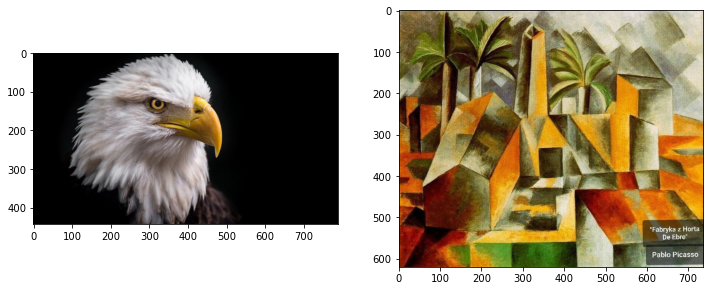

In [2]:
style_weight = 1e-6
content_weight = 2.5e-8

content_img = cv2.imread('eagle.jpg')
content_img = cv2.cvtColor(content_img, cv2.COLOR_BGR2RGB)

style_img = cv2.imread('picasso.jpg')
style_img = cv2.cvtColor(style_img, cv2.COLOR_BGR2RGB)

_ , ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].imshow(content_img)
ax[0].axis()
ax[1].imshow(style_img)
ax[1].axis()

In [3]:
content_layers = 'block5_conv2' 
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

In [4]:
model = vgg19.VGG19(weights="imagenet", include_top=False)
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
feature_extractor = Model(inputs=model.inputs, outputs=outputs_dict)

In [5]:
"""def get_gram_matrix(matrix):
    num_channels = matrix.shape[-1]
    res = []
    for i in range(num_channels):
        layer = content_img[:,:,i]
        layer = tf.transpose(layer)
        layer = tf.reshape(layer, -1)
        res.append(layer)
    res = tf.convert_to_tensor(res, 'float64')
    return tf.matmul(res, tf.transpose(res))"""

def get_gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram


def get_style_loss(style, combination):
    S = get_gram_matrix(style)
    C = get_gram_matrix(combination)
    channels = 3
    size = 488 * 788
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))


def get_content_loss(base_content, target):
    return tf.reduce_mean(tf.square(base_content - target))

In [6]:
def preprocess_img(img, dst_size):
    img = cv2.resize(img, dst_size)
    img = img[np.newaxis, :]
    img = vgg19.preprocess_input(img)
    return tf.convert_to_tensor(img)

def deprocess_img(img):
    img[:, :, 0] += 103.939
    img[:, :, 1] += 116.779
    img[:, :, 2] += 123.68
    img = np.clip(img, 0, 255).astype("uint8")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

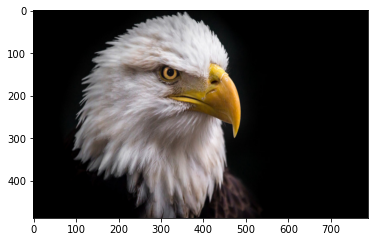

In [7]:
x = preprocess_img(content_img, dst_size=(788, 488))
temp_x = deprocess_img(x.numpy()[0])
plt.imshow(temp_x)

In [8]:
def calculate_loss(content_img, style_img, final_img):
    input_data = tf.concat([content_img, style_img, final_img], axis=0)
    result = feature_extractor(input_data)

    loss = tf.zeros(shape=())

    result_layers = result[content_layers]
    result_base = result_layers[0]
    result_final = result_layers[2]

    content_loss = get_content_loss(result_base, result_final)
    loss += content_weight * content_loss

    for style_layer in style_layers:
        result_layers = result[style_layer]
        result_style = result_layers[1]
        result_final = result_layers[2]
        style_loss = get_style_loss(result_style, result_final)
        loss += (style_weight / (len(style_layers))) * style_loss
        
    return loss

In [9]:
@tf.function
def compute_loss_and_gradient(content_img, style_img, final_img):
    with tf.GradientTape() as tape:
        loss = calculate_loss(content_img, style_img, final_img)
        print(loss)
    grad = tape.gradient(loss, final_img)
    return loss, grad

In [ ]:
optimizer = optimizers.SGD(
    optimizers.schedules.ExponentialDecay(
        initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96
    )
)


content_img = preprocess_img(content_img, dst_size=(788, 488))
style_img = preprocess_img(style_img, dst_size=(788, 488))
final_img = tf.Variable(content_img)

iterations = 200

for i in range(iterations):
    loss, grad = compute_loss_and_gradient(content_img, style_img, final_img)
    optimizer.apply_gradients([(grad, final_img)])
    print(i, loss)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Tensor("add_5:0", shape=(), dtype=float32)
0 tf.Tensor(28652.844, shape=(), dtype=float32)
1 tf.Tensor(23731.889, shape=(), dtype=float32)
2 tf.Tensor(19308.416, shape=(), dtype=float32)
3 tf.Tensor(16063.863, shape=(), dtype=float32)
4 tf.Tensor(13096.847, shape=(), dtype=float32)
5 tf.Tensor(10827.549, shape=(), dtype=float32)
6 tf.Tensor(9088.409, shape=(), dtype=float32)
7 tf.Tensor(7870.122, 